In [2]:
# check if config exists
try:
    config
except NameError:
    config_exists = False
else:
    config_exists = True

# make config if it does not exist already (e.g. passed in by papermill)
if not(config_exists):
    # set up some config for the experiment run
    config = {
        "data_path" : "C:/Users/nico_/Desktop/ITBA/TFI/global fishing watch/dataset/trollers.csv",
        "output_label": "trollers"
    }
print(config)

{'data_path': 'C:/Users/nico_/Desktop/ITBA/TFI/global fishing watch/dataset/trollers.csv', 'output_label': 'trollers'}


In [30]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

df = pd.read_csv(config['data_path'], header="infer", sep=",",error_bad_lines=False, engine ='python')

#Nos quedamos con los puntos que estan mayor a 3 millas nauticas de la costa.
df = df[(df['distance_from_shore'] >= 5556)]

#Nos quedamos solamente con los valores que estamos seguros que esta o no esta pescando.
df = df[(df['is_fishing'] == -1.0)  | (df['is_fishing'] == 1.0) ]

#Renombramos las columnas de la variable a predecir de si esta pescando o no.
df["is_fishing"] = np.where(df["is_fishing"] == 1.0, 'SI', 'NO')

#Dropeamos los que contienen el mismo timestamp.
df = df.drop_duplicates(subset='timestamp', keep="first")

#df['date_series'] = pd.to_datetime(df['timestamp'],unit='s')
#df = df.set_index('date_series') 

aux = df

print(len(df[df['is_fishing']=='SI']))
print(len(df[df['is_fishing']=='NO']))


1868
19530


BEFORE
1868
19530
AFTER
722
8150


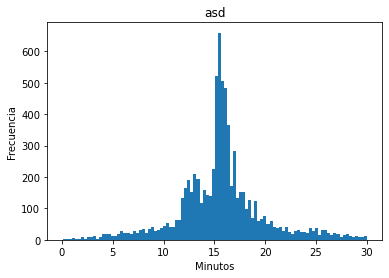

In [50]:
df = aux

df['datetime'] = pd.to_datetime(df['timestamp'],unit='s')

print("BEFORE")
print(len(df[df['is_fishing']=='SI']))
print(len(df[df['is_fishing']=='NO']))

df = df.resample('15Min',on='datetime').agg('first').dropna()  
df.reset_index(drop=True, inplace=True)

print("AFTER")
print(len(df[df['is_fishing']=='SI']))
print(len(df[df['is_fishing']=='NO']))

#print(df)
#Calculo la diferencia de tiempo entre puntos consecutivos.

import pandas as pd
import matplotlib.pyplot as plt

#Calculo la diferencia de tiempo entre puntos consecutivos.
df['timediff']= df.groupby('mmsi')['timestamp'].diff()

df_graph = df[(df['timediff'] <= 60*30) ]
df_graph = df_graph[(df_graph['timediff'] > 0) ]
plt.hist(df_graph['timediff']/60,bins=100)
plt.ylabel('Frecuencia')
plt.xlabel('Minutos')
plt.title(f'asd')
plt.show()

In [45]:
#EJEMPLO DE RESAMPLE PARA VER QUE FUNCIONA OK.
d = {'timestamp': [1, 2,60,59,61,3,4,60*2,60*4+1,60*7+1], 'valores': [3, 3,4,4,6,5,6,7,8,9]}
d = pd.DataFrame(data=d)

d['datetime'] = pd.to_datetime(d['timestamp'],unit='s')
print(d)

d = d.resample('1Min',on='datetime').agg('first').dropna()  
print(d)

   timestamp  valores            datetime
0          1        3 1970-01-01 00:00:01
1          2        3 1970-01-01 00:00:02
2         60        4 1970-01-01 00:01:00
3         59        4 1970-01-01 00:00:59
4         61        6 1970-01-01 00:01:01
5          3        5 1970-01-01 00:00:03
6          4        6 1970-01-01 00:00:04
7        120        7 1970-01-01 00:02:00
8        241        8 1970-01-01 00:04:01
9        421        9 1970-01-01 00:07:01
                     timestamp  valores            datetime
datetime                                                   
1970-01-01 00:00:00        1.0      3.0 1970-01-01 00:00:01
1970-01-01 00:01:00       60.0      4.0 1970-01-01 00:01:00
1970-01-01 00:02:00      120.0      7.0 1970-01-01 00:02:00
1970-01-01 00:04:00      241.0      8.0 1970-01-01 00:04:01
1970-01-01 00:07:00      421.0      9.0 1970-01-01 00:07:01


In [31]:
#There are multiple definitions for night, depending if it's for civil (-6°), nautical (-12°) or astronomical (-18°) purposes. 
# Just pick a treshold : if the sun is below, it's nighttime!

import ephem
import math
import datetime

def get_day_night(lat,lon,datetime): 
    sun = ephem.Sun()
    observer = ephem.Observer()
    # ↓ Define your coordinates here ↓
    observer.lat, observer.lon, observer.elevation = lat, lon, 0
    # ↓ Set the time (UTC) here ↓
    #observer.date = datetime.datetime.utcnow()
    observer.date=datetime
    sun.compute(observer)
    current_sun_alt = sun.alt
    if (current_sun_alt*180/math.pi) < -12.0 :
        return 2
    else:
        return 1
    
df['sun_state'] = df.apply(lambda x: get_day_night(x['lat'], x['lon'],x['datetime']), axis=1)

In [32]:
df["sun_state"].value_counts()

1    8934
2    5107
Name: sun_state, dtype: int64

Se pesca mas de noche, que de dia

In [33]:
print(df.groupby(["is_fishing"])[['sun_state']].describe(percentiles=[]))

           sun_state                                   
               count      mean       std  min  50%  max
is_fishing                                             
NO           12755.0  1.369894  0.482795  1.0  1.0  2.0
SI            1286.0  1.302488  0.459514  1.0  1.0  2.0


In [34]:
def haversine_np(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

def distance(x):
    y = x.shift()
    return haversine_np(x['lat'], x['lon'], y['lat'], y['lon']).fillna(0)

df['distance'] = df.groupby('mmsi').apply(distance).reset_index(level=0, drop=True)

In [35]:
#Convierto latitud y longitud a radianes
df['lat'] = np.radians(df['lat'])
df['lon'] = np.radians(df['lon'])

In [37]:
#Normalizamos la variable curso
df['course']=df['course']/360.0

In [38]:
#Agregar esto deberia de hacer robusto a mi algoritmo a LAT/LON y timestamps.

#Velocidad entre puntos a partir de la distancia        S = x(t2)-x(t1) / t2 - t1
df['S0']= df['distance']/df['timediff']
#Aceleracion rectilinea         A = S(t2)-S(t1) / t2 - t1
df['A0']= df.groupby('mmsi')['S0'].diff()/df['timediff']
#Jerk                           J = A(t2)-A(t1) / t2 - t1
df['J0']= df.groupby('mmsi')['A0'].diff()/df['timediff']
#Derivada del curso             Phi = C(t2)-C(t1) / t2 - t1
df['C0']= df.groupby('mmsi')['course'].diff()/df['timediff']
#2 Horas deberia de ser suficientemente informativo para saber el comportamiento del buque 
#Agregar paper.

#Velocidad promedio entre puntos    Vavg = V1 + V2 / 2
df['Vavg']  = df.groupby('mmsi')['speed'].transform(lambda x: x.rolling(2, 1).mean())


#Variacion de velocidad entre puntos Delta_S = V2 - V1 / 2 
df['Delta_S']= (df.groupby('mmsi')['speed'].diff())/2

#Curso promedio entre puntos        Cavg = C1 + C2 / 2
df['Cavg'] = df.groupby('mmsi')['course'].transform(lambda x: x.rolling(2, 1).mean())
#Variacion del curso                DeltaC = C2-C1/2
df['Delta_C']= (df.groupby('mmsi')['course'].diff())/2


In [39]:
number_lags = 7
columns_to_lag = ['speed','course','S0','A0','J0','C0','Delta_C','Delta_S','Vavg']

#df = pd.DataFrame(data={'vals':[5,4,3,2,1]})
for column in columns_to_lag:
    for lag in range(1, number_lags + 1):
        df[str(column) +'_lag_' + str(lag)] = df[column].shift(lag)


In [40]:
print(df.columns)

Index(['mmsi', 'timestamp', 'distance_from_shore', 'distance_from_port',
       'speed', 'course', 'lat', 'lon', 'is_fishing', 'source', 'datetime',
       'sun_state', 'distance', 'timediff', 'S0', 'A0', 'J0', 'C0', 'Vavg',
       'Delta_S', 'Cavg', 'Delta_C', 'speed_lag_1', 'speed_lag_2',
       'speed_lag_3', 'speed_lag_4', 'speed_lag_5', 'speed_lag_6',
       'course_lag_1', 'course_lag_2', 'course_lag_3', 'course_lag_4',
       'course_lag_5', 'course_lag_6', 'S0_lag_1', 'S0_lag_2', 'S0_lag_3',
       'S0_lag_4', 'S0_lag_5', 'S0_lag_6', 'A0_lag_1', 'A0_lag_2', 'A0_lag_3',
       'A0_lag_4', 'A0_lag_5', 'A0_lag_6', 'J0_lag_1', 'J0_lag_2', 'J0_lag_3',
       'J0_lag_4', 'J0_lag_5', 'J0_lag_6', 'C0_lag_1', 'C0_lag_2', 'C0_lag_3',
       'C0_lag_4', 'C0_lag_5', 'C0_lag_6'],
      dtype='object')


In [41]:
print(f'con NA={df.count()}')
df = df.dropna()
df.to_csv(f"../../df_procesado/{config['output_label']}_fe_15MIN_7lambda.csv",sep=",",index=False)  

print(f'sin NA={df.count()}')
#df.to_csv(f"../../df_procesado/{config['output_label']}_fe_15MIN_7lambda.csv",sep=",",index=False)  

In [ ]:
print(len(df[df['is_fishing']=='SI']))
print(len(df[df['is_fishing']=='NO']))